# Explainable Deep Learning

**Topic:** Explainable AI for Assistive Object Recognition  

**Name:** Aniwan Ailina


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ailina-aniwan/xai-explainable-deep-learning/blob/main/gradcam_analysis.ipynb)

## Dependencies & Imports

In [ ]:
# Install dependencies
!pip uninstall -y torch torchvision torchaudio grad-cam opencv-python opencv-python-headless >/dev/null 2>&1
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 \
    grad-cam==1.5.2 matplotlib Pillow==10.4.0 opencv-python-headless==4.10.0.84 --quiet

# Import libraries
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cv2

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.models import resnet50, ResNet50_Weights

# Check environment
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Clone the repo so Colab can access the images
!git clone https://github.com/ailina-aniwan/xai-explainable-deep-learning.git
%cd xai-explainable-deep-learning



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Using device: cpu


## Dataset Verification

Found 7 images


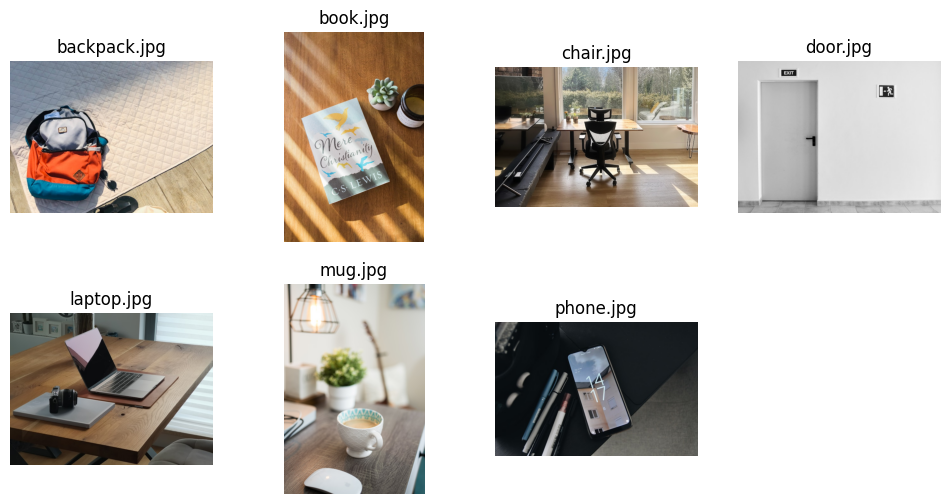

In [ ]:
image_paths = sorted(glob.glob("images/*"))
print("Found", len(image_paths), "images")
# Code written with AI assistance (ChatGPT, 10/06/2025)

plt.figure(figsize=(12, 6))
for i, path in enumerate(image_paths):
    img = Image.open(path)
    plt.subplot(2, len(image_paths)//2 + 1, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(path.split("/")[-1])
plt.show()

> Seven images were selected to represent everyday objects that accessibility tools might need to recognize — such as a **mug, phone, laptop, chair, door, book,** and **backpack**.  

> These items were chosen because they are common in indoor environments and belong to ImageNet classes that the pretrained ResNet-50 model can recognize.  Images were sourced from Unsplash, resized to 640×480 pixels, and verified to ensure good lighting, clear visibility, and neutral backgrounds.

## Load Pretrained Model

In [ ]:
# Load pretrained ResNet-50 model
from torchvision.models import resnet50, ResNet50_Weights

# Load pretrained weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)
model.eval()

# Get ImageNet class labels
idx_to_label = weights.meta["categories"]
print("Model loaded with", len(idx_to_label), "classes.")


Model loaded with 1000 classes.


## Preprocess and Predict

In [ ]:
# Code written with AI assistance (ChatGPT, 10/06/2025)
# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_and_preprocess(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    return img, input_tensor

# Predict function
def predict_image(image_path):
    img, tensor = load_and_preprocess(image_path)
    with torch.no_grad():
        outputs = model(tensor)
        probs = F.softmax(outputs, dim=1)
        top_prob, top_idx = probs.topk(1)
        label = idx_to_label[top_idx.item()]
    return img, label, top_prob.item()

# Run predictions on all images
image_paths = sorted(glob.glob("images/*"))
predictions = []

for path in image_paths:
    img, label, prob = predict_image(path)
    predictions.append((path, label, prob))
    print(f"{os.path.basename(path):<15} → {label:<25} ({prob*100:.2f}%)")

backpack.jpg    → backpack                  (28.00%)
book.jpg        → packet                    (6.69%)
chair.jpg       → dining table              (18.01%)
door.jpg        → refrigerator              (29.91%)
laptop.jpg      → notebook                  (11.31%)
mug.jpg         → cup                       (6.09%)
phone.jpg       → lipstick                  (10.75%)


## Visualize Predictions

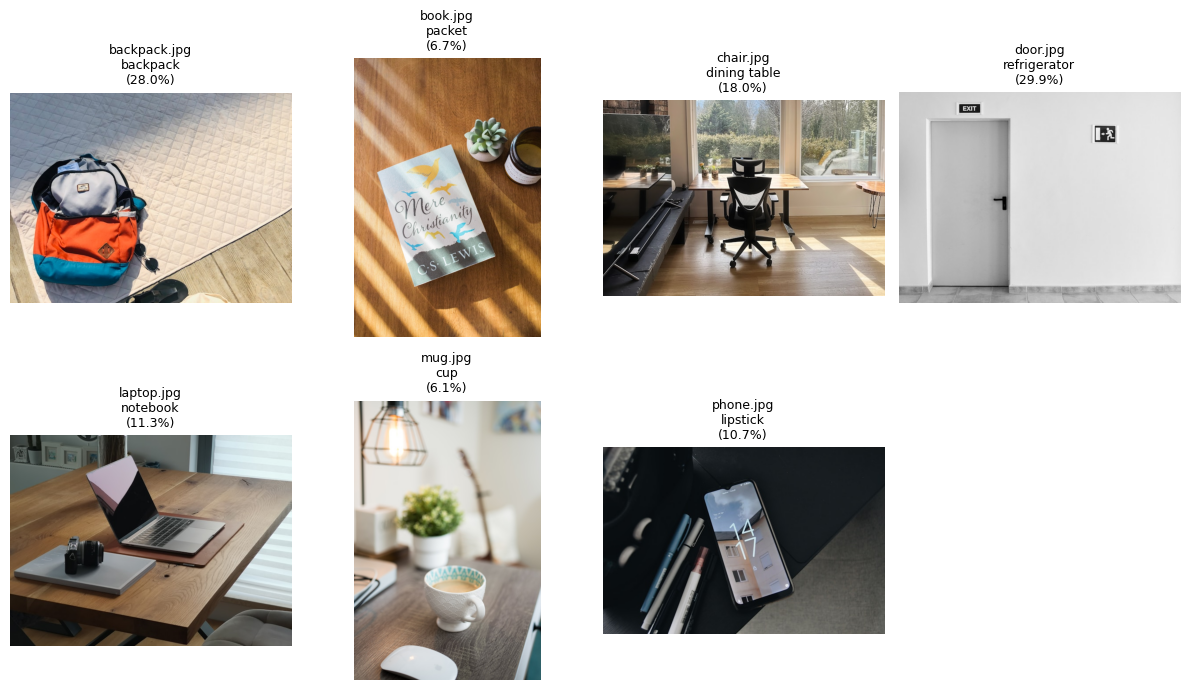

In [ ]:
plt.figure(figsize=(12, 7))
for i, (path, label, prob) in enumerate(predictions):
    img = Image.open(path)
    plt.subplot(2, len(predictions)//2 + 1, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(path)}\n{label}\n({prob*100:.1f}%)", fontsize=9)
plt.tight_layout()
plt.show()

> According to above outputs, we observed that the model occasionally misclassifies context-rich objects (e.g., book → packet, door → refrigerator), which provides an opportunity to explore whether Grad-CAM highlights the correct object region despite incorrect labeling.

## Grad-CAM Implementation

In [ ]:
# Utility function for Grad-CAM visualization
def generate_cam_visualization(model, target_layer, image_path, cam_algorithm):
    """Generate Grad-CAM heatmap and overlay for a single image."""
    # Load and normalize image
    rgb_img = np.array(Image.open(image_path).convert('RGB'))
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = rgb_img.astype(np.float32) / 255.0

    # Preprocess for model
    input_tensor = preprocess_image(
        rgb_img, mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ).to(device)

    # Initialize CAM object
    cam = cam_algorithm(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    del cam

    return rgb_img, grayscale_cam, visualization

# Code written with AI assistance (ChatGPT, 10/06/2025)


## Apply Grad-CAM and Variants

In [ ]:
target_layer = model.layer4[-1]

cam_methods = {
    "Grad-CAM": GradCAM,
    "Grad-CAM++": GradCAMPlusPlus,
    "Score-CAM": ScoreCAM
}

cam_results = {name: [] for name in cam_methods.keys()}

for path, label, prob in predictions:
    print(f"\nProcessing {os.path.basename(path)} ({label})")
    for name, algorithm in cam_methods.items():
        rgb_img, grayscale_cam, visualization = generate_cam_visualization(
            model, target_layer, path, algorithm)
        cam_results[name].append((path, visualization))



Processing backpack.jpg (backpack)


100%|██████████| 128/128 [03:54<00:00,  1.83s/it]



Processing book.jpg (packet)


100%|██████████| 128/128 [04:51<00:00,  2.28s/it]



Processing chair.jpg (dining table)


100%|██████████| 128/128 [05:07<00:00,  2.41s/it]



Processing door.jpg (refrigerator)


100%|██████████| 128/128 [08:02<00:00,  3.77s/it] 



Processing laptop.jpg (notebook)


100%|██████████| 128/128 [04:30<00:00,  2.11s/it]



Processing mug.jpg (cup)


100%|██████████| 128/128 [04:48<00:00,  2.26s/it]



Processing phone.jpg (lipstick)


100%|██████████| 128/128 [04:57<00:00,  2.33s/it]


## Visualization Grid

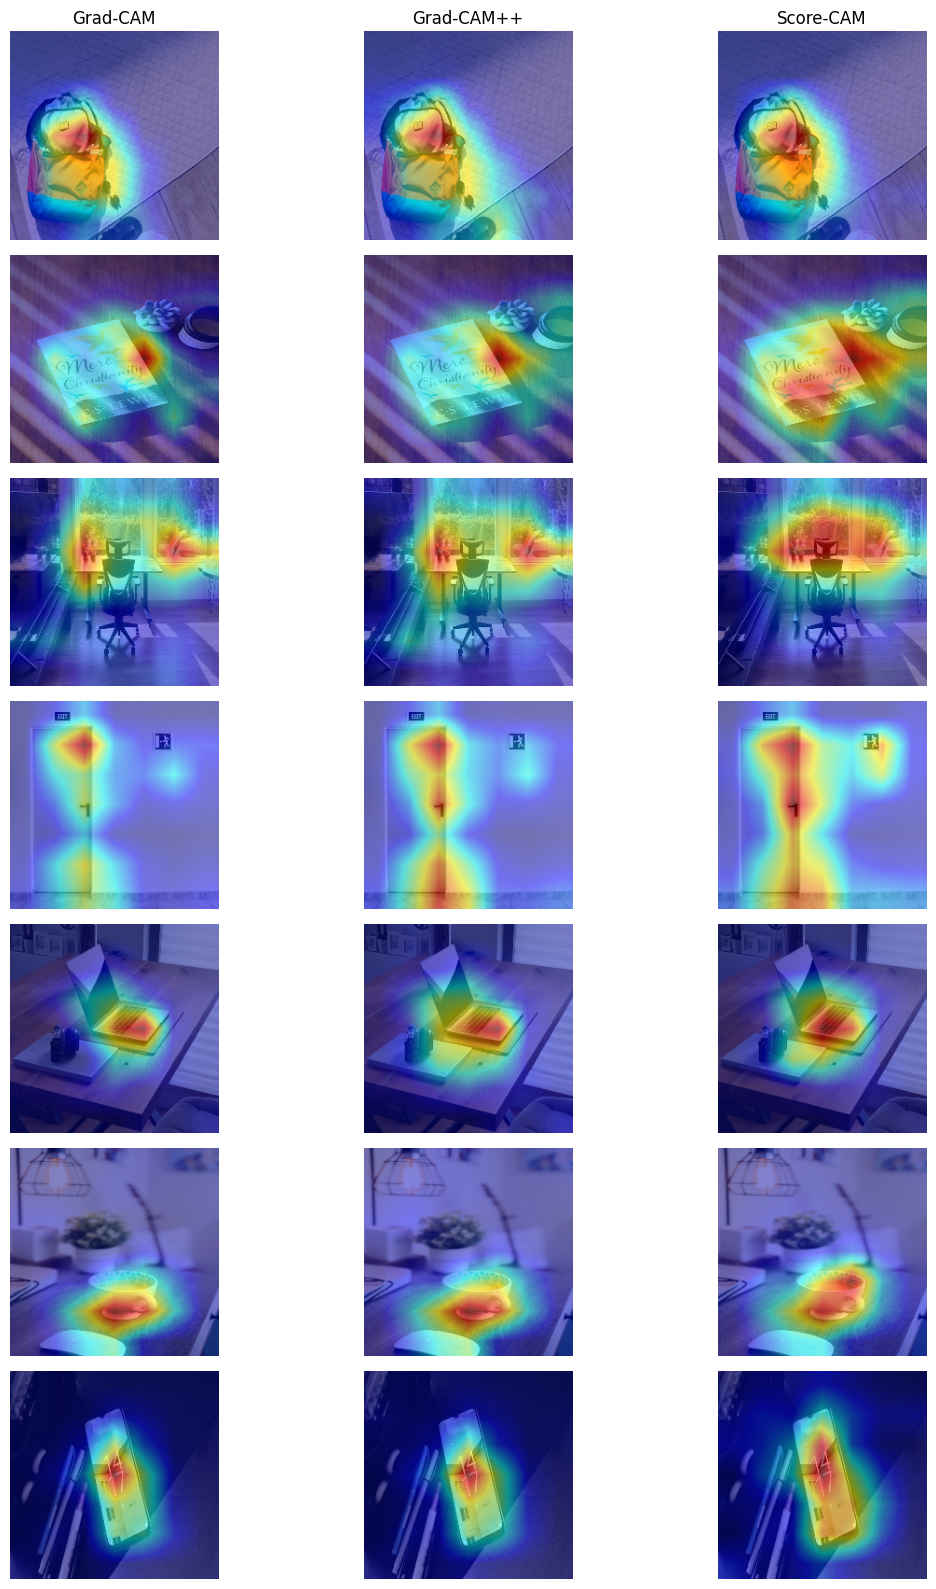

In [ ]:
# Display comparison grid
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, len(cam_methods), figsize=(12, 16))

for i, path in enumerate(image_paths):
    for j, (name, results) in enumerate(cam_results.items()):
        img = results[i][1]
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(name, fontsize=12)
        if j == 0:
            axes[i, j].set_ylabel(os.path.basename(path), fontsize=10)
plt.tight_layout()
plt.show()


## Comparative Analysis

According to the above Grad-CAM visualizations, the pretrained model generally attends to the salient areas corresponding to the main objects in each image. For example, the laptop and phone images show strong activations over the keyboard and screen, which means that the model focuses on semantically meaningful regions relevant to object recognition in assistive contexts. However, the attention sometimes diffuses to non-object areas that it still relies partly on non-object cues.

Among the methods, *Grad-CAM* produces the broadest and coarsest attention maps. It captures the overall object shape but often spreads activation across irrelevant regions, such as the table surface near the mug or the wall near the door. *Grad-CAM++*, in contrast, generates sharper and more localized heatmaps. It is more precise in identifying finer object details like the door handle or the rim of the mug with improved localization of the most discriminative features. *Score-CAM* delivers smoother and more context-sensitive maps by averaging multiple activation responses. While this sometimes enhances interpretability in scenes with complex lighting or overlapping objects, it can also dilute focus by blending background context with object cues.

## Reflection

Overall, the visualizations show that the model’s attention is generally appropriate that focuses on the primary objects rather than arbitrary regions. For instance, in the laptop and phone images, the activations align closely with the functional areas users interact with, such as the keyboard and screen. This means that the model’s internal reasoning is at least partially interpretable and grounded in semantically meaningful cues.

Some surprising behaviors, however, still point to potential limitations. In the “book” and “door” examples, the model misclassified the objects despite attending to their correct physical regions. The door, for example, was predicted as a refrigerator even though the heatmap clearly centered on the door itself. These cases show that attention alignment does not always guarantee correct classification that the model can visually “see” the right object yet conceptually misinterpret it, therefore showing the gap between perception and understanding.

From an accessibility standpoint, these findings are highly relevant. Assistive AI systems must not only produce accurate outputs but also justify them transparently to build user trust. Grad-CAM visualizations make it possible to verify whether an assistive recognition model is attending to meaningful features, which is especially important for users with visual impairments who rely on AI explanations for environmental awareness. Explainability therefore is significant in ensuring such systems are interpretable, trustworthy, and ethically deployable. Future work could involve fine-tuning the model on accessibility-focused datasets or evaluating attention mechanisms in transformer-based architectures to improve both interpretability and robustness.